## Classification of SVHN using Transfer Learning from pre-trained MNIST CNN

### The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

- 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 0.
- 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data
- Comes in two formats:
  1. Original images with character level bounding boxes.
  2. MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).

- The dataset that we will be using in this notebook contains 42000 training samples and 18000 testing samples

Dataset link : https://www.kaggle.com/sasha18/street-view-house-nos-h5-file

In [ ]:
#import tensorflow
import tensorflow as tf

In [ ]:
#The SVHN dataset is provided in the form of h5. We can extract the data as train and test
                                                                #using the following script. 
import h5py

data=h5py.File('SVHN_single_grey1.h5','r')

X_train=data['X_train'][:]
y_train=data['y_train'][:]

X_test=data['X_test'][:]
y_test=data['y_test'][:]

data.close()

In [ ]:
#scaling the data
x_train=X_train/255.
x_test=X_test/255.

In [ ]:
x_train.shape

(42000, 32, 32)

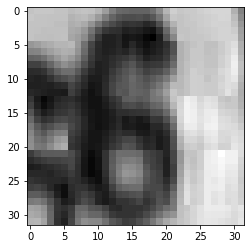

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[20,:,:],cmap='gray')

In [ ]:
y_train[20]

6

In [ ]:
# Resize the images as 28x28 
#(MNIST dataset size is 28x28, as we are using the MNIST model weight, 
                                                     #we need to resize these images as 28x28 )
import cv2
import numpy as np
X_train_resize=np.zeros((42000,28,28))

for i in range(42000):
    X_train_resize[i,:,:]=cv2.resize(x_train[i],dsize=(28,28))

X_test_resize=np.zeros((18000,28,28))
for i in range(18000):
    X_test_resize[i,:,:]=cv2.resize(x_test[i],dsize=(28,28))

In [ ]:
X_train_resize.shape

(42000, 28, 28)

In [ ]:
#Reshape the train and test datasets to make them 4-D
xtrain1=X_train_resize.reshape(42000,28,28,1) # u can also use np.expand_dim
xtest1=X_test_resize.reshape(18000,28,28,1)

In [ ]:
#Encoding the target variable
from tensorflow.keras.utils import to_categorical
ytrain=to_categorical(y_train,num_classes=10)
ytest=to_categorical(y_test,num_classes=10)
ytrain[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# Import the libraries required for CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

In [ ]:
# The CNN model architecture must be same as the one we have builded for MNIST dataset,
# because our idea is to apply the weights trained for MNIST dataset to apply here on SVHN data model
classifier1=Sequential()

classifier1.add(Conv2D(16,(3,3),input_shape=(28,28,1),activation ='relu'))
classifier1.add(MaxPooling2D(pool_size=(2,2)))

classifier1.add(Conv2D(32,(3,3),activation ='relu'))
classifier1.add(MaxPooling2D(pool_size=(2,2)))

classifier1.add(Flatten())

classifier1.add(Dense(units=64,activation='relu'))
classifier1.add(Dense(units=10,activation='softmax'))


In [ ]:
#Apply the MNIST data model weight on the above CNN architecture
classifier1.load_weights('my_digit_model.h5')

In [ ]:
# Compilation statergy
classifier1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# Evaluating the "SVHN digit" test data on the model with the "MNIST digit" weights
classifier1.evaluate(xtest1,ytest)
#This model producing the accuracy of around 22 percent only as the two dataset are differnt (eventhough both contains digit)

18000/18000 [==============================] - 2s 133us/sample - loss: 2.6429 - accuracy: 0.2174


[2.642934987809923, 0.21744445]

In [ ]:
# To improve the performance of this model, we need to re-train some section of the weights 
# with respect to SVHN dataset.

#One approach is keep the weights of the convolution layer as it is, but re-train the weights of the 
#dense layers (hidden and output layer)
# This is know as Transfer Learning through feature extraction

In [ ]:
classifier1.layers #accessing the layers

In [ ]:
#Accessing the layer name
for layer in classifier1.layers:
    print(layer.name)

conv2d_12
max_pooling2d_12
conv2d_13
max_pooling2d_13
flatten_5
dense_10
dense_11


In [ ]:
# Trainability nature of each layer.
#by default all layer weights are trainable
for layer in classifier1.layers:
    print(layer.trainable)

True
True
True
True
True
True
True


In [ ]:
#freeze the convolution layer and train only the dense layer
for layer in classifier1.layers:
    if ('dense' not in layer.name):
        layer.trainable=False
    if('dense' in layer.name):
        layer.trainable=True

In [ ]:
for layer in classifier1.layers:
    print(layer.name,layer.trainable)
# False indicating that these layers can't be trainable (i.e the weights are freezed)

conv2d_12 False
max_pooling2d_12 False
conv2d_13 False
max_pooling2d_13 False
flatten_5 False
dense_10 True
dense_11 True


In [ ]:
classifier1.summary()
# Non trainable parameters = convolution layer parameters = 160 +4640 =4800

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                51264     
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [ ]:
# Training the model. In this step only the weights of dense layers will be updated
# convolution layer weights remain same(same as MNIST model weights)
classifier1.fit(xtrain1,ytrain,batch_size=32,epochs=10,validation_data=(xtest1,ytest))
# Model performance improved drastically

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 20s 483us/sample - loss: 0.8078 - accuracy: 0.7591 - val_loss: 0.5641 - val_accuracy: 0.8397
Epoch 2/10
42000/42000 [==============================] - 20s 474us/sample - loss: 0.4907 - accuracy: 0.8580 - val_loss: 0.4747 - val_accuracy: 0.8641
Epoch 3/10
42000/42000 [==============================] - 20s 466us/sample - loss: 0.4122 - accuracy: 0.8814 - val_loss: 0.4318 - val_accuracy: 0.8763
Epoch 4/10
42000/42000 [==============================] - 18s 417us/sample - loss: 0.3624 - accuracy: 0.8931 - val_loss: 0.4060 - val_accuracy: 0.8837
Epoch 5/10
42000/42000 [==============================] - 17s 410us/sample - loss: 0.3251 - accuracy: 0.9035 - val_loss: 0.3939 - val_accuracy: 0.8880
Epoch 6/10
42000/42000 [==============================] - 17s 416us/sample - loss: 0.2943 - accuracy: 0.9127 - val_loss: 0.3880 - val_accuracy: 0.8917
Epoch 7/10
42000/42000 [====================

In [ ]:
# The approach is along with tuning dense layer weights, we can also retrain few last convolution layers
#This is know as Transfer Learning through Fine Tuning
for layer in classifier1.layers:
    print(layer.name,layer.trainable)
classifier1.layers[2].trainable=True
classifier1.layers[3].trainable=True
classifier1.layers[4].trainable=True
print("After unfreezing last convolution layer")
for layer in classifier1.layers:
    print(layer.name,layer.trainable)

conv2d_12 False
max_pooling2d_12 False
conv2d_13 False
max_pooling2d_13 False
flatten_5 False
dense_10 True
dense_11 True
After unfreezing last convolution layer
conv2d_12 False
max_pooling2d_12 False
conv2d_13 True
max_pooling2d_13 True
flatten_5 True
dense_10 True
dense_11 True


In [ ]:
# Train the model. In this step along with all the dense layers, last convolution layer 
                                                           #weights also will be updated
classifier1.fit(xtrain1,ytrain,batch_size=32,epochs=10,validation_data=(xtest1,ytest))

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 20s 474us/sample - loss: 0.1931 - accuracy: 0.9424 - val_loss: 0.4056 - val_accuracy: 0.8972
Epoch 2/10
42000/42000 [==============================] - 21s 505us/sample - loss: 0.1798 - accuracy: 0.9463 - val_loss: 0.3997 - val_accuracy: 0.8971
Epoch 3/10
42000/42000 [==============================] - 20s 487us/sample - loss: 0.1643 - accuracy: 0.9510 - val_loss: 0.4052 - val_accuracy: 0.8979
Epoch 4/10
42000/42000 [==============================] - 17s 416us/sample - loss: 0.1530 - accuracy: 0.9539 - val_loss: 0.4206 - val_accuracy: 0.8964
Epoch 5/10
42000/42000 [==============================] - 17s 410us/sample - loss: 0.1402 - accuracy: 0.9576 - val_loss: 0.4326 - val_accuracy: 0.8972
Epoch 6/10
42000/42000 [==============================] - 19s 448us/sample - loss: 0.1297 - accuracy: 0.9614 - val_loss: 0.4577 - val_accuracy: 0.8959
Epoch 7/10
42000/42000 [====================

In [ ]:
# Reduce overfitting - Include dropout layer
classifier1=Sequential()

classifier1.add(Conv2D(16,(3,3),input_shape=(28,28,1),activation ='relu'))
classifier1.add(MaxPooling2D(pool_size=(2,2)))

classifier1.add(Conv2D(32,(3,3),activation ='relu'))
classifier1.add(MaxPooling2D(pool_size=(2,2)))
classifier1.add(Dropout(0.2))

classifier1.add(Flatten())

classifier1.add(Dense(units=64,activation='relu'))
classifier1.add(Dropout(0.2))
classifier1.add(Dense(units=10,activation='softmax'))

In [ ]:
for layer in classifier1.layers:
    print(layer.name,layer.trainable)

conv2d_8 True
max_pooling2d_8 True
conv2d_9 True
max_pooling2d_9 True
dropout_2 True
flatten_3 True
dense_6 True
dropout_3 True
dense_7 True


In [ ]:
classifier1.load_weights('my_digit_model.h5')

In [ ]:
for layer in classifier1.layers:
    if ('dense' not in layer.name):
        layer.trainable=False
    if('dense' in layer.name):
        layer.trainable=True

In [ ]:
classifier1.layers[2].trainable=True

In [ ]:
classifier1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
classifier1.fit(xtrain1,ytrain,batch_size=32,epochs=5,validation_data=(xtest1,ytest))

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 15s 357us/sample - loss: 0.3726 - accuracy: 0.8846 - val_loss: 0.3525 - val_accuracy: 0.8967
Epoch 2/5
42000/42000 [==============================] - 15s 359us/sample - loss: 0.3566 - accuracy: 0.8882 - val_loss: 0.3420 - val_accuracy: 0.9003
Epoch 3/5
42000/42000 [==============================] - 15s 361us/sample - loss: 0.3501 - accuracy: 0.8887 - val_loss: 0.3416 - val_accuracy: 0.9018
Epoch 4/5
42000/42000 [==============================] - 15s 360us/sample - loss: 0.3441 - accuracy: 0.8914 - val_loss: 0.3500 - val_accuracy: 0.8983
Epoch 5/5
42000/42000 [==============================] - 13s 309us/sample - loss: 0.3333 - accuracy: 0.8946 - val_loss: 0.3400 - val_accuracy: 0.8995


In [ ]:
#including dropout layer reducing the overfitting 